# Observer 패턴

## O.1 소개

* Observer 패턴은 Behavioral Design Pattern
* 알람을 설정해 놓고, 시간이 되면 알려주는 경우

* 디자인패턴 요소

요소 | 설명
---|---
name | Observer
problem | 1:n관계에서의 정보 갱신
solution | 정보사용자를 등록하고, 정보가 변동하는 경우 알려줌.
consequence | loose coupling, 확장성

* 사례
    * 'Weather' (HFDP Ch2)
    * Turtle - 아기거북이가 어디로 가면, 엄마거북이가 다른 곳에 있더라도 쫓아 간다.


## O.2 문제

* 누군가에 대해(정보공급자) 알고 싶어하는 다수의 사용자가 존재. 1:n 관계.
* 그 사용자가 늘어날수록, 알려주는 문제
* 확장성 문제
    * 사용자를 추가하거나, 해제하는 문제
    * 정보를 갱신하는 방법이 바뀌면, 사용자에게 알려주는 방법도 변경되어야 한다.

* polling - 데이터를 원하는 측 (정보사용자)이 계속 묻는다
* 비효율적 - 통화중인데 계속 전화를 거는 것

## O.3 설계

* 인터페이스 분리 (ISP Interface Segregation Principle)
* 구체적인 클래스 상속
* 클라이언트는 구체클래스 보다는 추상적 클래스 사용
* Subject
    * Observable, Publisher
    * 상태가 변경이 되면 알림 기능 (notify)
    * 알림 대상이 되는 Observer를 사전에 등록 (register)
* Observers
    * Subscriber
    * Subject의 상태가 변경이 되면 그 내용을 받아서 반영함 (update)

* 효과
    * 데이터를 원하는 display는 등록하고 기다린다
    * 통화중이면 전화를 또 걸지 않고 '전화 자동발신'하고 다른 작업을 함

In [1]:
import iplantuml

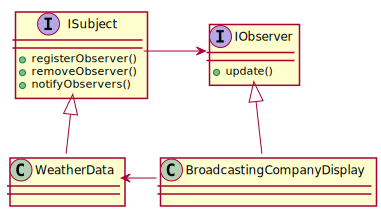

In [3]:
%%plantuml

@startuml

ISubject -right-> IObserver
ISubject <|-- WeatherData
IObserver <|-- BroadcastingCompanyDisplay
WeatherData <-left- BroadcastingCompanyDisplay

Interface ISubject {
    +registerObserver()
    +removeObserver()
    +notifyObservers()
}

Interface IObserver {
    +update()
}
@enduml

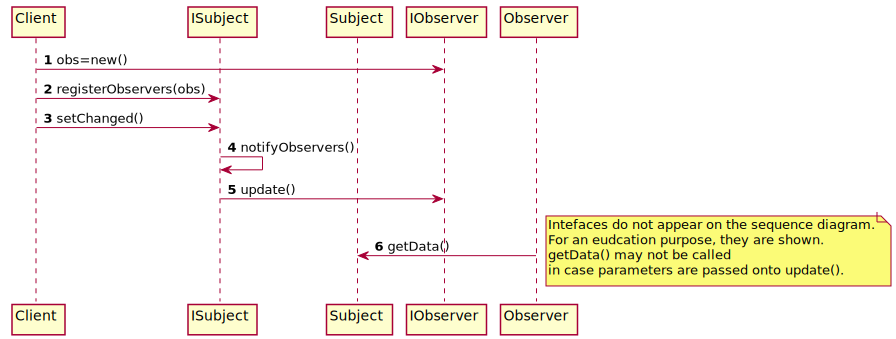

In [2]:
%%plantuml

@startuml
participant Client
participant ISubject
participant Subject
participant IObserver
participant Observer

autonumber
Client -> IObserver:obs=new()
Client -> ISubject:registerObservers(obs)
Client -> ISubject:setChanged()
ISubject -> ISubject:notifyObservers()
ISubject -> IObserver:update()
Observer -> Subject:getData()

note right
    Intefaces do not appear on the sequence diagram.
    For an eudcation purpose, they are shown.
    getData() may not be called
    in case parameters are passed onto update().
end note

@enduml

## O.4 사례

### O.4.1 날씨

* 객체에서 나누어지는 서로 다른 기능이 있는 경우, 인터페이스로 분리
* 교재 HFDP Ch2 'Weather'
* 정보공급자는 정기적으로 계속 온도, 습도, 기압을 측정, 수집
* 온도 getTemperature(), 습도 getHummidity(), 기압 getPressure() 수집.
* 방송국, 농사, 운동경기 관련 사이트에서 그 정보를 사용
* 정된 날씨 데이터는 배포measurementsChanged()

* 패턴을 적용하기 전

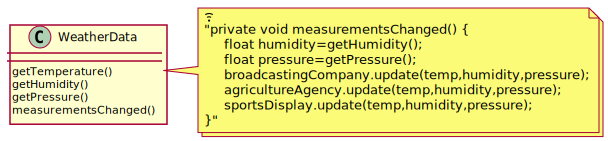

In [4]:
%%plantuml
@startuml
class WeatherData {
    getTemperature()
    getHumidity()
    getPressure()
    measurementsChanged()
}
note right
   <&wifi>
   "private void measurementsChanged() {
        float humidity=getHumidity();
        float pressure=getPressure();
        broadcastingCompany.update(temp,humidity,pressure);
        agricultureAgency.update(temp,humidity,pressure);
        sportsDisplay.update(temp,humidity,pressure);
   }"
end note
@enduml

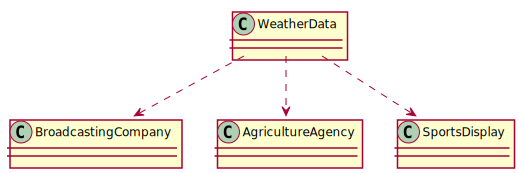

In [5]:
%%plantuml
@startuml
WeatherData ..> BroadcastingCompany
WeatherData ..> AgricultureAgency
WeatherData ..> SportsDisplay
@enduml

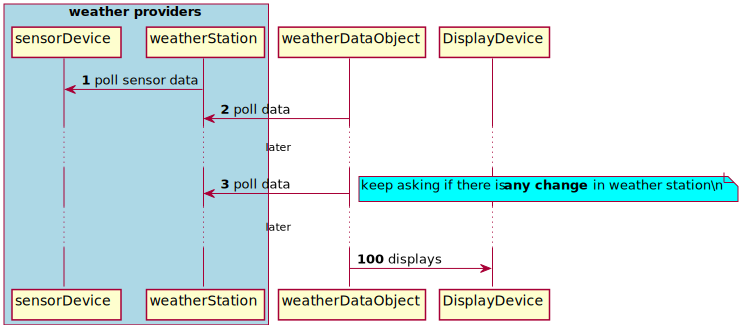

In [6]:
%%plantuml

@startuml

box "weather providers" #LightBlue
  participant sensorDevice
  participant weatherStation
end box

autonumber
sensorDevice <- weatherStation: poll sensor data
weatherStation <- weatherDataObject: poll data
... later ...
weatherStation <- weatherDataObject: poll data

... later ...
autonumber 100
note right #aqua
  keep asking if there is **any change** in weather station\n
end note
weatherDataObject -> DisplayDevice: displays

@enduml

* 패턴의 적용

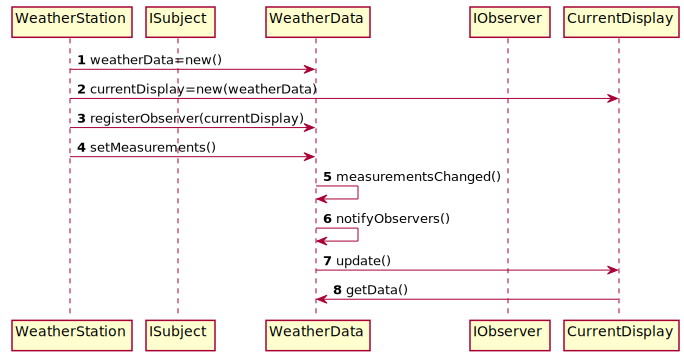

In [7]:
%%plantuml

@startuml
participant WeatherStation
participant ISubject
participant WeatherData
participant IObserver
participant CurrentDisplay

autonumber
WeatherStation -> WeatherData:weatherData=new()
WeatherStation -> CurrentDisplay:currentDisplay=new(weatherData)
WeatherStation -> WeatherData:registerObserver(currentDisplay)
WeatherStation -> WeatherData:setMeasurements()
WeatherData -> WeatherData:measurementsChanged()
WeatherData -> WeatherData:notifyObservers()
WeatherData -> CurrentDisplay:update()
CurrentDisplay -> WeatherData:getData()
@enduml

In [ ]:
# %load /Users/media/Code/git/sd/src/headfirst/observer/weather/Subject.java
package headfirst.observer.weather;

public interface Subject {
	public void registerObserver(Observer o);
	public void removeObserver(Observer o);
	public void notifyObservers();
}


In [ ]:
# %load /Users/media/Code/git/sd/src/headfirst/observer/weather/Observer.java
package headfirst.observer.weather;

public interface Observer {
	public void update(float temp, float humidity, float pressure);
}


In [ ]:
# %load /Users/media/Code/git/sd/src/headfirst/observer/weather/WeatherData.java
package headfirst.observer.weather;

import java.util.*;

public class WeatherData implements Subject {
	private ArrayList observers;
	private float temperature;
	private float humidity;
	private float pressure;
	
	public WeatherData() {
		observers = new ArrayList();
	}
	
	public void registerObserver(Observer o) {
		observers.add(o);
	}
	
	public void removeObserver(Observer o) {
		int i = observers.indexOf(o);
		if (i >= 0) {
			observers.remove(i);
		}
	}
	
	public void notifyObservers() {
		for (int i = 0; i < observers.size(); i++) {
			Observer observer = (Observer)observers.get(i);
			observer.update(temperature, humidity, pressure);
		}
	}
	
	public void measurementsChanged() {
		notifyObservers();
	}
	
	public void setMeasurements(float temperature, float humidity, float pressure) {
		this.temperature = temperature;
		this.humidity = humidity;
		this.pressure = pressure;
		measurementsChanged();
	}
	
	public float getTemperature() {
		return temperature;
	}
	
	public float getHumidity() {
		return humidity;
	}
	
	public float getPressure() {
		return pressure;
	}
}


In [ ]:
# %load /Users/media/Code/git/sd/src/headfirst/observer/weather/CurrentConditionsDisplay.java
package headfirst.observer.weather;
	
public class CurrentConditionsDisplay implements Observer, DisplayElement {
	private float temperature;
	private float humidity;
	private Subject weatherData;
	
	public CurrentConditionsDisplay(Subject weatherData) {
		this.weatherData = weatherData;
		weatherData.registerObserver(this);
	}
	
	public void update(float temperature, float humidity, float pressure) {
		this.temperature = temperature;
		this.humidity = humidity;
		display();
	}
	
	public void display() {
		System.out.println("Current conditions: " + temperature 
			+ "F degrees and " + humidity + "% humidity");
	}
}


In [ ]:
# %load /Users/media/Code/git/sd/src/headfirst/observer/weather/WeatherStation.java
package headfirst.observer.weather;

import java.util.*;

public class WeatherStation {

	public static void main(String[] args) {
		WeatherData weatherData = new WeatherData();
	
		CurrentConditionsDisplay currentDisplay = 
			new CurrentConditionsDisplay(weatherData);
		StatisticsDisplay statisticsDisplay = new StatisticsDisplay(weatherData);
		ForecastDisplay forecastDisplay = new ForecastDisplay(weatherData);

		weatherData.setMeasurements(80, 65, 30.4f);
		weatherData.setMeasurements(82, 70, 29.2f);
		weatherData.setMeasurements(78, 90, 29.2f);
	}
}


In [ ]:
# %load /Users/media/Code/git/sd/src/headfirst/strategy/FlyRocketPowered.java
package headfirst.strategy;

public class FlyRocketPowered implements FlyBehavior {
	public void fly() {
		System.out.println("I'm flying with a rocket");
	}
}


In [13]:
%pwd

u'/Users/media/Dropbox/Me/toCopy/smu'

In [16]:
# change to the root directory
!javac -d classes/ -sourcepath src src/headfirst/observer/weather/*.java
!java -cp classes/ headfirst.observer.weather.WeatherStation

/Users/media/Code/git/sd
javac: file not found: src/headfirst/observer/weather/*.java
Usage: javac <options> <source files>
use -help for a list of possible options
오류: 기본 클래스 headfirst.observer.weather.WeatherStation을(를) 찾거나 로드할 수 없습니다.


### O.4.2 거북이

#### O.4.2.1 아기 거북이 지켜보기

* 내용
    * 아기거북이가 여기 저기 다닌다.
    * 엄마거북이는 아기거북이의 위치가 바뀌면 알아야 하고, 바뀐 위치로 신속하게 이동해야 한다.

* 구현 주의:
    * 자바에서 제공하는 Observer, Observable을 사용했다.
    * 따라서 거북이와 Observable를 모두 상속받는 다중상속이 허용되지 않아서 (자바에서는 java.util.Observable를 클래스로 구현했슴), 거북이를 연관관계로 가지도록 MomTurtle을 구현했다.
    * 자바 java.util.Observable의 protected로 패키지클래스 및 상속클래스 외에는 이 함수를 사용하지 못하도록 했다.

        ```
         69     protected void setChanged() {
         70         myCurpos=baby.getPos();
         71     }
        ```

    * Observer의 update를 호출할 때, argument에 메시지가 포함된다.
        ```
         65     public void notifyObservers() {
         66         for(Observer o:obs)
         67             o.update(this, 1);
         68     }
         ```


In [ ]:
# %load /Users/media/Code/git/sd/src/com/sd/turtle/TurtleObserverMain.java
/* 
 * @author jsl
 * @since 20160310
 * Demonstrate the Observable class and the Observer interface. 
 * The MomTurtle observes and moves to the position of the BabyTurtle.
 * 1) mom moves and baby also moves
 * 2) baby's notification is set on to let mom know
*/ 

package com.sd.turtle;

import java.util.Observer;
import java.util.Observable;
import java.util.ArrayList;
import java.awt.geom.Point2D.Double;
import java.awt.Color;
import ch.aplu.turtle.*;

public class TurtleObserverMain {
    public static void main(String[] args) {
        System.out.println("--Observer pattern demo");
        //turtle subject
        BabyTurtle baby=new BabyTurtle();
        //turtle observer
        MomTurtle mom=new MomTurtle();
        baby.addObserver(mom);
        //mom goes to somewhere
        mom.moveTo(100,100);
        //baby moves and let mom know it
        baby.move(100,-100);
        //protected method -> others can not set any changes
        baby.setChanged();
        baby.notifyObservers();
    }
}

class MomTurtle extends Turtle implements Observer {
    Double babyCurpos;
    public MomTurtle() {
        setColor(Color.red);
        label("mom turtle");
    }
    public void update(Observable o, Object arg) {
        System.out.println("update() called, count is " + ((Integer)arg).intValue()); 
        babyCurpos=((BabyTurtle)o).myCurpos;
        System.out.println("current pos" + babyCurpos);
        moveTo(babyCurpos);
    }
}

//BayTurtle did not inherit Turtle
//because multiple inheritance is not allowed in java
class BabyTurtle extends Observable {
    Turtle baby;
    Double myCurpos;
    ArrayList<Observer> obs;
    public BabyTurtle() {
        baby = new Turtle();
        myCurpos=baby.getPos();
        obs=new ArrayList<Observer>();
    }
    public void addObserver(Observer o) {
        obs.add(o);
    }
    public void notifyObservers() {
        for(Observer o:obs)
            o.update(this, 1);
    }
    protected void setChanged() {
        myCurpos=baby.getPos();
    }
    public void move(int x, int y) {
        baby.moveTo(x,y);
    }
}


In [ ]:
!javac -d classes/ -cp lib/aplu5.jar:classes/ -sourcepath src/ src/com/sd/turtle/TurtleObserverMain.java 
!java -cp lib/aplu5.jar:classes/ com.sd.turtle.TurtleObserverMain

#### O.4.2.2 거북이 키/마우스로 움직이기

* 키보드/ 마우스에 이벤트가 발생하면 거북이를 움직인다.
* Observer패턴을 사용한다.
* KeyAdapter, MouseAdapter, MouseMotionAdapter를 사용한다.
